In [2]:
# 全局设置
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../../config/HDF5DBConfig.json").connect()

# 策略测试

在 QuantStudio 中, 用户通过实现事先规定好的接口来定义自己的投资策略, 每个策略均需继承自 `Strategy`, 该类位于 `BackTest` 模块下, 需要用户实现的方法有:
* `Strategy.init`: 策略初始化方法, 在回测开始之前调用, 用户可以在该方法中设置策略的参数或初始化一些变量;
* `Strategy.genSignal`: 策略信号生成方法, 在回测的每个时点调用, 用户可以自定义自己的策略信号, 并将该信号作为此方法的返回值;
* `Strategy.trade`: 策略交易方法, 该方法以 `Strategy.genSignal` 的返回值作为输入, 完成从信号到交易订单的转化.
    
从上面的描述可知, QuantStudio 将策略信号和交易订单分离, 策略的主要逻辑体现在信号的生成中, 而信号到交易订单的转化属于交易算法的部分, 对于同一种类型的信号其交易算法可以通用. 当然, 上述三个方法, 必须实现的是 `Strategy.trade`, 对于比较简单的策略, 用户可以将所有的逻辑都放在这个方法里.

# 买入持有策略

==========历史回测==========
1. 初始化
耗时 : 0.34
2. 循环计算


100% (12 of 12) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


耗时 : 3.56
3. 结果生成
耗时 : 0.04
总耗时 : 3.94


,绝对表现
起始时点,2017-01-26
结束时点,2017-12-29
时点数,12
总收益率,4.37%
年化收益率,4.74%
年化波动率,2.29%
Sharpe比率,2.07
收益风险比,2.07
胜率,66.67%
最大回撤率,0.51%

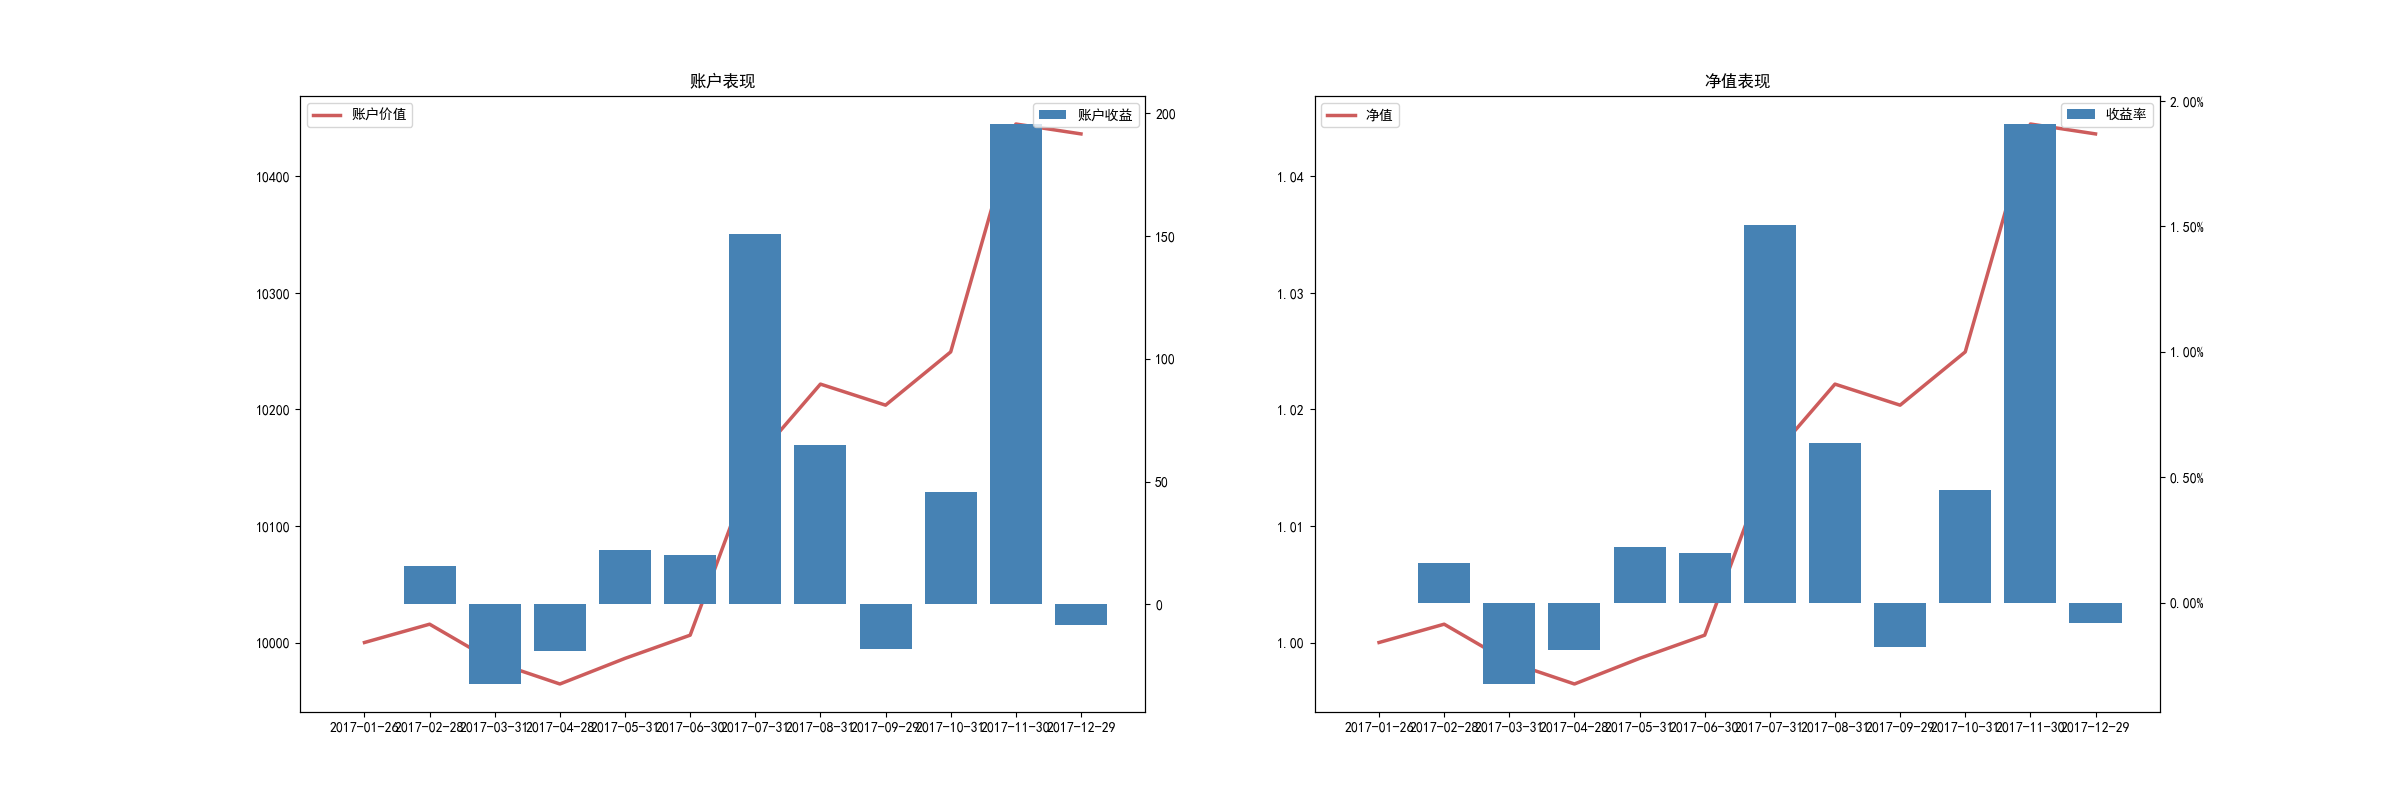

In [3]:
# 买入持有策略

class BuyAndHoldStrategy(QS.BackTest.Strategy.Strategy):
    """买入并持有策略"""
    def init(self):
        self.ModelArgs["TargetID"] = "000001.SZ"# 进行交易的目标 ID
    def trade(self, idt, trading_record, signal):
        TargetID = self.ModelArgs["TargetID"]
        if self.Accounts[0].PositionNum[TargetID]==0:
            self.Accounts[0].order(TargetID, 1)

FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(start_dt=dt.datetime(2017, 1, 1), end_dt=dt.datetime(2017, 12, 31))
DTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)
IDs = FT.getID()

# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
Close = FT.getFactor("close")
CFT.addFactors(factor_list=[Close])
CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# 添加回测模块
iModule = BuyAndHoldStrategy(name="买入并持有策略")
iAccount = QS.BackTest.Strategy.DefaultAccount(market_ft=CFT)
iAccount.Args["初始资金"] = 1e4
iAccount.Args["负债上限"] = 0
iAccount.Args["交易延迟"] = False
iAccount.Args["最新价"] = "close"
iAccount.Args["买入限制"]["交易费率"] = 0.0
iAccount.Args["卖出限制"]["交易费率"] = 0.0
iModule.Accounts.append(iAccount)
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 查看结果
display(Model)